In [798]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')

In [799]:
def loadSingleFile( tfile, treename, flatenndf=False ):
    ttree = uproot.open(tfile)
    data = pd.DataFrame(ttree[treename].arrays(library="np"))
    return data

## Prepare data files

In [1376]:
### PREPARE DATA ####
RUN = 13269
PERIOD = "Run_4"
PECUT = 150

SHOW_TRACKS = False
DUMP = False

PATH = "/exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/"
OUTPATH = "/exp/icarus/data/users/mvicenzi/pmt-calibration/residualsdb/" + PERIOD + "/"
COSMICSDB = "/exp/icarus/data/users/mvicenzi/pmt-database/pmt_cosmics_timing_data/"
LASERDB = "/exp/icarus/data/users/mvicenzi/pmt-database/pmt_laser_timing_data/"

FILENAME = PATH + "run{}_matched_light_tracks.root".format(RUN)

APPLY_LASER = True
#LASERCORR = LASERDB + "pmt_laser_timing_data_run08046_from8270-8304.csv"
#LASERCORR = LASERDB + "pmt_laser_timing_data_run09301_from9305.csv"
#LASERCORR = LASERDB + "pmt_laser_timing_data_run09773_from9773.csv"
#LASERCORR = LASERDB + "pmt_laser_timing_data_run10908_from10982.csv"
#LASERCORR = LASERDB + "pmt_laser_timing_data_run11590_from11641.csv"
LASERCORR = LASERDB + "pmt_laser_timing_data_run12837_from12838.csv"

APPLY_COSMICS = True
#COSMICSCORR = COSMICSDB + "pmt_cosmics_timing_data_run09773_from10085.csv"
#COSMICSCORR = COSMICSDB + "pmt_cosmics_timing_data_run08046_from8461.csv"
#COSMICSCORR = OUTPATH + "run12014_residuals_laseronly.csv"
#COSMICSCORR = OUTPATH + "run9337_residuals_laseronly.csv"
#COSMICSCORR = OUTPATH + "run10085_residuals_laseronly.csv"
#COSMICSCORR = OUTPATH + "run11813_residuals_laseronly.csv"
COSMICSCORR = OUTPATH + "run12970_residuals_laseronly.csv"

suffix = "nocorr"
if APPLY_LASER:
    suffix = "laseronly"
if APPLY_LASER and APPLY_COSMICS:
    suffix = "lasercosmics"

OUTFILE = OUTPATH + "run{}_residuals_{}.csv".format(RUN,suffix)
    
print("Reading {}".format(FILENAME))

Reading /exp/icarus/data/users/mvicenzi/pmt-calibration/track_matches/run13269_matched_light_tracks.root


In [1377]:
### Get optical data
dfw = loadSingleFile(FILENAME, "trackLightMatchW")
dfe = loadSingleFile(FILENAME, "trackLightMatchE")
df = pd.concat([dfe, dfw])
del dfw
del dfe

print("Considering {} track-flash matches".format( len(df) ) )

Considering 19729 track-flash matches


In [1378]:
df.head()

,run,event,cryo,flash_id,flash_time,flash_y,flash_z,track_T0,track_charge_z,track_start_x,...,track_dir_z,track_length,flash_nhits,channel_id,pmt_time,pmt_pe,pmt_amplitude,pmt_x,pmt_y,pmt_z
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.000000,706.218018,-195.564941,...,-0.420343,316.021454,38,"[70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 8...","[338.3912058160156, 338.3971859625, 338.391205...","[121.43319621757891, 99.04308862283132, 127.35...","[998.4000244140625, 953.7999877929688, 789.799...","[-371.07000732421875, -371.07000732421875, -37...","[-76.25, -129.0500030517578, -23.4500007629394...","[523.739990234375, 573.6199951171875, 573.6199..."
1,13269,10329,0,4,-138.954544,-34.396618,128.129562,-138182.250000,120.332596,-95.141373,...,0.342779,430.592987,38,"[40, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5...","[-138.7528044800781, -138.75479868261718, -138...","[69.3841638616299, 86.10135239850828, 57.00348...","[468.0, 614.2000122070312, 252.60000610351562,...","[-371.07000732421875, -371.07000732421875, -37...","[-76.25, -23.450000762939453, 82.1500015258789...","[-74.81999969482422, -24.940000534057617, -24...."
2,13269,10341,0,7,-805.935364,-30.240925,-57.622818,-798690.812500,-49.947987,-230.650421,...,-0.552491,411.358368,42,"[30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[-805.7288123296875, -805.7267780960938, -805....","[56.479831499224794, 60.328533041368374, 73.30...","[472.6000061035156, 427.79998779296875, 643.0,...","[-371.07000732421875, -371.07000732421875, -37...","[-76.25, -23.450000762939453, -129.05000305175...","[-274.3399963378906, -224.4600067138672, -174...."
3,13269,10437,0,13,-405.450043,-21.157482,372.649780,-403358.125000,374.730927,-156.603561,...,-0.067992,324.603058,35,"[53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 6...","[-405.2467931207031, -405.24679266679686, -405...","[51.502000875369376, 63.49851033909163, 67.936...","[465.6000061035156, 691.2000122070312, 453.799...","[-371.07000732421875, -371.07000732421875, -37...","[-23.450000762939453, -129.0500030517578, -23....","[174.5800018310547, 224.4600067138672, 224.460..."
4,13269,180516,0,3,-118.714119,-9.165677,-398.857361,-116459.070312,-406.772552,-74.261337,...,-0.404613,401.967438,39,"[15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 2...","[-118.50080002050781, -118.4987992868164, -118...","[91.21399277469784, 86.27746224838171, 107.292...","[809.7999877929688, 545.2000122070312, 804.400...","[-371.07000732421875, -371.07000732421875, -37...","[-129.0500030517578, -23.450000762939453, -76....","[-573.6199951171875, -573.6199951171875, -523...."


## Check tracks

In [1379]:
if SHOW_TRACKS:

    fig, ax = plt.subplots(1,2, figsize=(12, 4.3),dpi=200)

    #ax[0].plot( [df.track_end_z, df.track_start_z], [df.track_end_y, df.track_start_y], color='black', lw=0.1 )
    ax[0].axhline(y=125., linestyle="dashed")
    ax[0].axhline(y=-175., linestyle="dashed")

    ax[1].axvline(x=209., linestyle="dotted", color="C1", label="Cathode")
    ax[1].axvline(x=-209., linestyle="dotted", color="C1")
    #ax[1].plot( [df.track_end_x, df.track_start_x], [df.track_end_y, df.track_start_y], color='black', lw=0.1 )
    ax[1].axhline(y=125., linestyle="dashed")
    ax[1].axhline(y=-175., linestyle="dashed")

    # consider steeper angles?
    _sel_dir_z= (df.track_dir_z > -0.25) & (df.track_dir_z < 0.25 ) 
    _sel_dir_x = (df.track_dir_x > -0.1) & (df.track_dir_x < 0.1 )
    _seldir= _sel_dir_z
    ax[0].plot( [df[_seldir].track_end_z, df[_seldir].track_start_z], [df[_seldir].track_end_y, df[_seldir].track_start_y], color='black', lw=0.1 )
    ax[1].plot( [df[_seldir].track_end_x, df[_seldir].track_start_x], [df[_seldir].track_end_y, df[_seldir].track_start_y], color='black', lw=0.1 )
    print( len(df), len(df[_seldir]) )

    ax[0].set_ylabel("Y [cm]" )  
    ax[0].set_xlabel("Z [cm]" )
    ax[0].grid(alpha=0.5)

    ax[1].set_ylabel("Y [cm]" )  
    ax[1].set_xlabel("X [cm]" ) 
    ax[1].grid(alpha=0.5)

    watermark = r'$\mathbf{ICARUS}\,$ Data' +' - Run {}'.format(RUN)
    ax[0].text(0.01, 1.05, watermark, fontsize=12, color='black', alpha=1,
         ha='left', va='center', transform=ax[0].transAxes)

    plt.legend()

    # save the image as pdf!
    #savepath = "figs/tracks/run{}_tracks_standard_selection.pdf".format(RUN)
    #print("Saving to {}...".format(savepath))
    #plt.savefig(savepath,dpi=200)

    plt.show()

## Explode the dataframe

In [1380]:
## Explode the dataframe 
df = df.explode(["pmt_time", "pmt_x", "pmt_y", "pmt_pe", "pmt_z", "pmt_amplitude","channel_id"])

## Add timing corrections (if needed!)

In [1381]:
## Import and use laser correction
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT PREVIOUS STAGES
## note: laser corrections are in ns!

lasercorr = pd.read_csv(LASERCORR, sep=r'\s*,\s*', engine='python')
lasercorr = lasercorr.rename(columns={'channel': 'channel_id'})
lasercorr.set_index(["channel_id"], inplace=True)
lasercorr["t_signal"] = lasercorr["t_signal"]/1e3  #convert ns to us

df = df.join( lasercorr[["t_signal"]], on=["channel_id"])

if APPLY_LASER:
    print("Applying laser corrections from {}...".format(LASERCORR))
    df['pmt_time'] = df['pmt_time'] - df['t_signal']  #CURRENTLY ADDING LASER CORRECTIONS!

Applying laser corrections from /exp/icarus/data/users/mvicenzi/pmt-database/pmt_laser_timing_data/pmt_laser_timing_data_run12837_from12838.csv...


In [1382]:
## Import and use cosmic corrections
## WARNING: DO NOT USE IF CORRECTIONS WERE ALREADY APPLIED AT PREVIOUS STAGES
## note: cosmics corrections are in ns!

cosmicscorr = pd.read_csv(COSMICSCORR, sep=r'\s*,\s*', engine='python')
cosmicscorr = cosmicscorr.rename(columns={'channel': 'channel_id'})
cosmicscorr.set_index(["channel_id"])
cosmicscorr["mean_residual_ns"] = cosmicscorr["mean_residual_ns"]/1e3  #convert ns to us

df = df.join( cosmicscorr[["mean_residual_ns"]], on=["channel_id"])

if APPLY_COSMICS:
    print("Applying cosmics corrections from {}...".format(COSMICSCORR))
    df['pmt_time'] = df['pmt_time'] - df['mean_residual_ns']  #CURRENTLY ADDING COSMICS CORRECTIONS!

Applying cosmics corrections from /exp/icarus/data/users/mvicenzi/pmt-calibration/residualsdb/Run_4/run12970_residuals_laseronly.csv...


In [1383]:
#df.loc[df["pmt_pe"]>150,["event","cryo","flash_id","pmt_y","channel_id","pmt_time",'t_signal','mean_residual_ns']]

In [1384]:
# drop unneed columns
df = df.drop(columns=["t_signal"])
df = df.drop(columns=["mean_residual_ns"])

## Computing fit and residuals

In [1385]:
_sel = (df.pmt_pe > PECUT)
meandf = df[_sel][["run", "event", "cryo", "flash_id", "pmt_time", "pmt_pe", "pmt_y"]].groupby(["run", "event", "cryo", "flash_id", "pmt_y"]).apply( 
    lambda x : pd.Series( {
        "mean_time" : np.mean(x.pmt_time),
        "weight_mean_time" : np.average(x.pmt_time, weights=x.pmt_pe), 
        "error_mean_time": np.std(x.pmt_time) / np.sqrt(len(x.pmt_time)),
    }) ).reset_index()

meandf = meandf.groupby(["run", "event", "cryo", "flash_id"]).agg(list)

print("PE cut leaves {} tracks".format( len(meandf) ))

/tmp/ipykernel_1371/4187764002.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meandf = df[_sel][["run", "event", "cryo", "flash_id", "pmt_time", "pmt_pe", "pmt_y"]].groupby(["run", "event", "cryo", "flash_id", "pmt_y"]).apply(


PE cut leaves 18939 tracks


In [1386]:
N = 4 # minimum number of quotas available for a good fit (at least 1 pmt >PECUT in each) 
meandf = meandf[meandf["pmt_y"].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) >= N)]

print("Minimum quotas cut leaves {} tracks".format( len(meandf ) ))

Minimum quotas cut leaves 18921 tracks


In [1387]:
meandf.head()

pmt_y  \
run   event cryo flash_id                                                      
13269 25    0    9         [-129.0500030517578, -76.25, -23.4500007629394...   
            1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      37    0    5         [-129.0500030517578, -76.25, -23.4500007629394...   
            1    4         [-129.0500030517578, -76.25, -23.4500007629394...   
                 5         [-129.0500030517578, -76.25, -23.4500007629394...   

                                                                   mean_time  \
run   event cryo flash_id                                                      
13269 25    0    9         [-45.59944221809083, -45.60220890732422, -45.6...   
            1    2         [316.3600169982422, 316.35800178095707, 316.35...   
      37    0    5         [288.0739953990886, 288.0727491161458, 288.073...   
            1    4         [129.6202802656901, 129.61925889501956, 129.62...   
                 5         [-2.7031090645950315, -2.702766149590556, -2.7...   

                                                            weight_mean_time  \
run   event cryo flash_id                                                      
13269 25    0    9         [-45.60061408677077, -45.60212349931904, -45.6...   
            1    2         [316.3594779019865, 316.3575571284719, 316.356...   
      37    0    5         [288.0740133915264, 288.0718596246595, 288.073...   
            1    4         [129.62013459073145, 129.61927599450402, 129.6...   
                 5         [-2.703323493902198, -2.7028800445086425, -2.7...   

                                                             error_mean_time  
run   event cryo flash_id                                                     
13269 25    0    9         [0.00199502335572307, 0.0003109868743769381, 0...  
            1    2         [0.0005912172202719499, 0.0003622764350940016,...  
      37    0    5         [0.00029875815936243746, 0.0008073221926614472...  
            1    4         [0.00018209601907572456, 0.0002430821119757111...  
                 5         [0.0010582255760300727, 0.0009191464634141172,...

In [1388]:
def getdiff( y, t):
    # max y is on top : cosmics are going towards decreasing y 
    return t[np.argmin(y)] - t[np.argmax(y)]

# Define a linear model: t = intercept + slope * y
def linear_model(x, intercept, slope):
    return intercept + slope * x

def fittime( y, t ):

    if(len(y)<4 or len(t)<4):
        print("Not enough data points for linear regression: y = %s, t = %s", y, t)
        return 0,0,0
    
    # initial guess
    y_range = np.max(y) - np.min(y)
    slope0 = (np.max(t) - np.min(t)) / y_range if y_range !=0 else 0
    intercept0 = np.median(t) - slope0 * np.median(y)
    initp0 = [intercept0, slope0]

    try:

        popt, _ = curve_fit(linear_model, y, t, p0=initp0)
        return popt[0], popt[1], 1
    
        #old implementation... gave trouble for RUN-3..
        #res= stats.linregress(y, t)
        #return res.intercept,  res.slope
    
    except Exception as e:
        print("Fitting failed:", e)
        return 0,0,0

def residuals( tobs, y, a, b ):
    return tobs -  ( a + b*y )

In [1389]:
meandf["diff_time"] = meandf.apply( lambda x : getdiff( x.pmt_y, x.mean_time ), axis=1 ) 
meandf[["intercept", "slope", "status"]] = meandf.apply(lambda x : fittime(x.pmt_y, x.mean_time ), axis=1, result_type="expand" )

/tmp/ipykernel_1371/1642041446.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(linear_model, y, t, p0=initp0)


In [1390]:
meandf.head()

pmt_y  \
run   event cryo flash_id                                                      
13269 25    0    9         [-129.0500030517578, -76.25, -23.4500007629394...   
            1    2         [-129.0500030517578, -76.25, -23.4500007629394...   
      37    0    5         [-129.0500030517578, -76.25, -23.4500007629394...   
            1    4         [-129.0500030517578, -76.25, -23.4500007629394...   
                 5         [-129.0500030517578, -76.25, -23.4500007629394...   

                                                                   mean_time  \
run   event cryo flash_id                                                      
13269 25    0    9         [-45.59944221809083, -45.60220890732422, -45.6...   
            1    2         [316.3600169982422, 316.35800178095707, 316.35...   
      37    0    5         [288.0739953990886, 288.0727491161458, 288.073...   
            1    4         [129.6202802656901, 129.61925889501956, 129.62...   
                 5         [-2.7031090645950315, -2.702766149590556, -2.7...   

                                                            weight_mean_time  \
run   event cryo flash_id                                                      
13269 25    0    9         [-45.60061408677077, -45.60212349931904, -45.6...   
            1    2         [316.3594779019865, 316.3575571284719, 316.356...   
      37    0    5         [288.0740133915264, 288.0718596246595, 288.073...   
            1    4         [129.62013459073145, 129.61927599450402, 129.6...   
                 5         [-2.703323493902198, -2.7028800445086425, -2.7...   

                                                             error_mean_time  \
run   event cryo flash_id                                                      
13269 25    0    9         [0.00199502335572307, 0.0003109868743769381, 0...   
            1    2         [0.0005912172202719499, 0.0003622764350940016,...   
      37    0    5         [0.00029875815936243746, 0.0008073221926614472...   
            1    4         [0.00018209601907572456, 0.0002430821119757111...   
                 5         [0.0010582255760300727, 0.0009191464634141172,...   

                           diff_time   intercept     slope  status  
run   event cryo flash_id                                           
13269 25    0    9          0.004904  -45.603129 -0.000025     1.0  
            1    2          0.006889  316.355735 -0.000032     1.0  
      37    0    5          0.001673  288.072924 -0.000006     1.0  
            1    4         -0.000714  129.620416  0.000005     1.0  
                 5          0.002394   -2.705010 -0.000017     1.0

In [1391]:
# Putting fit back in the exploded dataframe, then compute the residual
# This should work for every channel_id
# this is using all slopes, including possible "negative" ones
dfg = df.join( meandf[["intercept", "slope", "status"]], on=["run", "event", "cryo", "flash_id"], how='inner')

# TEST: only positive slopes
#dfg = df.join( meandf[meandf.slope<0][["intercept", "slope"]], on=["run", "event", "cryo", "flash_id"], how='inner')

dfg["residuals"] = dfg.apply( lambda x : residuals(x.pmt_time, x.pmt_y, x.intercept, x.slope), axis=1 ) 

# Keep only the residuals on relevant PMT for that event
dfg = dfg[(dfg.pmt_pe>PECUT) & (dfg.status>0)]

print("Flash-tracks used for the computation of residuals: {}".format( len(dfg.groupby(["run", "event", "cryo", "flash_id"])) ) )

Flash-tracks used for the computation of residuals: 18921


In [1392]:
dfg.head()

,run,event,cryo,flash_id,flash_time,flash_y,flash_z,track_T0,track_charge_z,track_start_x,...,pmt_time,pmt_pe,pmt_amplitude,pmt_x,pmt_y,pmt_z,intercept,slope,status,residuals
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.0,706.218018,-195.564941,...,338.197393,249.826628,2156.800049,-371.070007,-129.050003,623.5,338.194781,-0.000017,1.0,0.000414
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.0,706.218018,-195.564941,...,338.197151,218.208676,1918.0,-371.070007,-23.450001,623.5,338.194781,-0.000017,1.0,0.001970
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.0,706.218018,-195.564941,...,338.196518,367.927763,2965.600098,-371.070007,-76.25,673.380005,338.194781,-0.000017,1.0,0.000438
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.0,706.218018,-195.564941,...,338.197762,200.032737,1103.599976,-371.070007,29.35,673.380005,338.194781,-0.000017,1.0,0.003480
0,13269,10317,0,4,338.191864,-29.572372,687.779968,339479.0,706.218018,-195.564941,...,338.197905,246.351186,2158.0,-371.070007,-76.25,723.26001,338.194781,-0.000017,1.0,0.001825


In [1393]:
if DUMP:
    print("Dumping exploded fit results...")
    dfg.to_csv("DUMP_run{}_{}.csv".format(RUN,suffix), index=False, float_format='%.6e')

## Group and save residuals

In [1394]:
# now group the residual by channel, computing the mean residual for each of them
# this is the final output which can then be saved!
us_to_ns = 1e3
thisdfg = dfg.groupby(["channel_id"]).apply(
    lambda x : pd.Series( { 
            'x': np.mean(x.pmt_x),
            'y': np.mean(x.pmt_y),
            'z': np.mean(x.pmt_z),
            'entries' : int(len(x.residuals)), 
            'pecut' : PECUT,
            'mean_residual_ns' : np.mean(x.residuals)*us_to_ns,
            'std_residual_ns' : np.std(x.residuals)*us_to_ns,
            'emean_ns' : np.std(x.residuals)*us_to_ns/len(x.residuals)
        })).reset_index()

thisdfg['entries'] = thisdfg['entries'].astype(int)

/tmp/ipykernel_1371/2775649494.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  thisdfg = dfg.groupby(["channel_id"]).apply(


In [1395]:
thisdfg.head(10)
#print(len(thisdfg))
#print(360-len(thisdfg))
#print(np.unique(thisdfg.channel_id.to_numpy()))

,channel_id,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
0,0,-371.070007,-76.250000,-872.900024,210,150.0,0.659807,2.340177,0.011144
1,1,-371.070007,29.350000,-872.900024,103,150.0,0.325669,2.436353,0.023654
2,2,-371.070007,-129.050003,-823.020020,131,150.0,0.849265,2.154393,0.016446
3,3,-371.070007,-23.450001,-823.020020,275,150.0,0.429731,2.394992,0.008709
4,4,-371.070007,82.150002,-823.020020,239,150.0,0.067390,2.619061,0.010958
5,5,-371.070007,-129.050003,-773.140015,22,150.0,-0.103927,1.211410,0.055064
6,6,-371.070007,-23.450001,-773.140015,649,150.0,0.133379,2.688258,0.004142
7,7,-371.070007,82.150002,-773.140015,482,150.0,0.173784,2.922947,0.006064
8,8,-371.070007,-76.250000,-723.260010,663,150.0,0.344366,2.123487,0.003203
9,9,-371.070007,29.350000,-723.260010,670,150.0,0.117451,2.714596,0.004052


In [1396]:
print("Saving residuals to {}...".format(OUTFILE))
thisdfg.to_csv(OUTFILE, index=False, float_format='%.4f')

Saving residuals to /exp/icarus/data/users/mvicenzi/pmt-calibration/residualsdb/Run_4/run13269_residuals_lasercosmics.csv...


#### Add lines with PMTs that are off (for DB files)

In [1397]:
rdf = pd.read_csv(OUTFILE)

# list of PMT channels at 0 voltage from HV files + disconnected pmts:
offCHs = []
if PERIOD == "Run_2" or PERIOD=="Run_1":
    offCHs = [350, 248, 215, 190, 161, 139, 127, 103, 131, 59, 52, 21, 5, 71]
else: # for Run_3 onwards...
    offCHs = [215, 103, 71 ]

In [1398]:
def readPlacements(file="/exp/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv"):
    geo = pd.read_csv(file,sep=",")
    geo.drop(columns=["entry","subentry"],inplace=True)
    return geo

geo = readPlacements(file="/exp/icarus/data/users/mvicenzi/pmt-calibration/input/pmt_positions.csv")

In [1399]:
dictionary = {'channel_id':[ a for a in offCHs],
        'x':[ geo["pmt_x"].iloc[a] for a in offCHs],
        'y':[ geo["pmt_y"].iloc[a] for a in offCHs],
        'z':[ geo["pmt_z"].iloc[a] for a in offCHs],
        'entries': [ 0 for a in offCHs],
        'pecut': [ 0. for a in offCHs],
        'mean_residual_ns': [ 0. for a in offCHs],
        'std_residual_ns': [ 0. for a in offCHs],
        'emean_ns': [ 0. for a in offCHs]        
       }

In [1400]:
addf = pd.DataFrame(dictionary)
rdf = pd.concat([rdf,addf], ignore_index=True)
rdf.sort_values(by="channel_id", inplace=True)

In [1401]:
rdf.to_csv(OUTFILE, index=False, float_format='%.4f')

## Looking at some residuals

In [1402]:
selected_channel = 267
residuals = dfg[dfg.channel_id==selected_channel].residuals.values

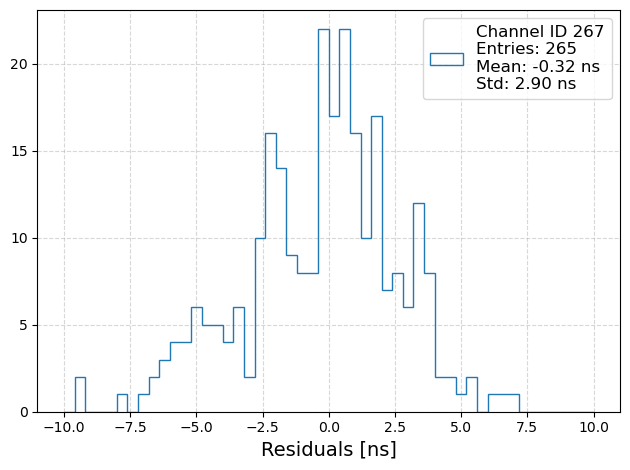

In [1403]:
fig = plt.figure(dpi=100)

lab = "Channel ID "+str(selected_channel)+"\n"
lab += "Entries: {}\n".format(len(residuals))
lab += "Mean: {:.2f} ns\n".format(np.nanmean(residuals*1e3))
lab += "Std: {:.2f} ns".format(np.nanstd(residuals*1e3))

plt.hist( residuals*1e3, bins=50, histtype='step', range=(-10,10), label=lab)
#plt.ylabel("# entries", fontsize=16)
plt.xlabel("Residuals [ns]", fontsize=14)
plt.tight_layout()
plt.grid(linestyle="dashed", alpha=0.5)
plt.legend(fontsize=12)
#plt.savefig("figs/run{}_channel_{}_residuals_test.pdf".format(RUN,selected_channel),dpi=150)
plt.show()

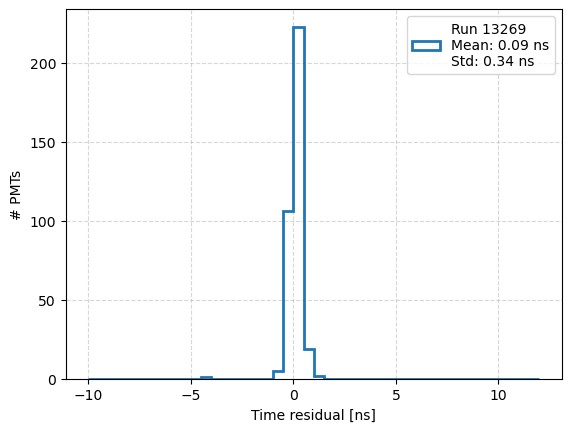

In [1404]:
# Plotting full distribution 
fig = plt.figure(dpi=100)

rmin=-10
rmax=12
r=(rmin,rmax)
s=0.5
b=int((rmax-rmin)/s)

res = thisdfg.mean_residual_ns.to_numpy()

lab = "Run {}\nMean: {:.2f} ns\nStd: {:.2f} ns".format(RUN,np.nanmean(res),np.nanstd(res))

plt.hist(res, bins=b, linewidth=2, range=r, histtype="step", label=lab)

plt.xlabel("Time residual [ns]")
plt.ylabel("# PMTs")
plt.legend()
plt.grid(linestyle="dashed", alpha=0.5)
#plt.savefig("figs/run{}_residuals_test.png".format(RUN),dpi=100)
plt.show()

## Looking at slope

In [1405]:
slopes = meandf["slope"].values
len(slopes)

18921

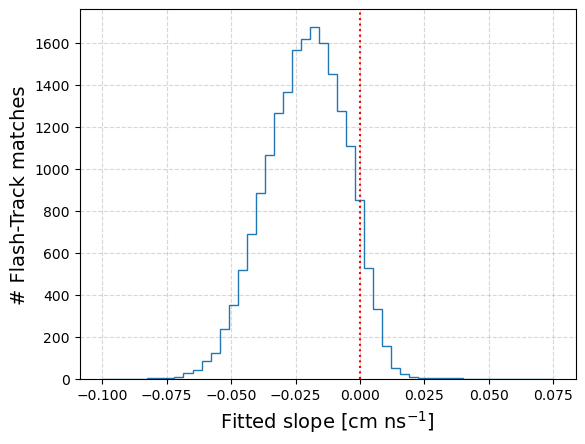

In [1406]:
fig = plt.figure(dpi=100)

plt.hist( slopes*1e3, bins=50, range=(-0.1,0.075), histtype='step')
plt.ylabel("# Flash-Track matches", fontsize=14)
plt.xlabel("Fitted slope [cm ns$^{-1}$]", fontsize=14)

plt.axvline(x=0.,color="red",linestyle="dotted")

#plt.tight_layout()
plt.grid(linestyle="dashed",alpha=0.5)
#plt.legend()
#plt.savefig("figs/run{}_slope_distribution_test.png".format(RUN),dpi=100)
plt.show()


In [1407]:
rdf.head(7)

,channel_id,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
0,0,-371.07,-76.25,-872.90,210,150.0,0.6598,2.3402,0.0111
1,1,-371.07,29.35,-872.90,103,150.0,0.3257,2.4364,0.0237
2,2,-371.07,-129.05,-823.02,131,150.0,0.8493,2.1544,0.0164
3,3,-371.07,-23.45,-823.02,275,150.0,0.4297,2.3950,0.0087
4,4,-371.07,82.15,-823.02,239,150.0,0.0674,2.6191,0.0110
5,5,-371.07,-129.05,-773.14,22,150.0,-0.1039,1.2114,0.0551
6,6,-371.07,-23.45,-773.14,649,150.0,0.1334,2.6883,0.0041
